# Exploring hurricane features and clustering methods

## Step 0: Same set up as the starter notebook

In [4]:
import os
cwd=os.getcwd()

cwd_data=cwd+'/data'

if not os.path.exists(cwd_data):
    os.mkdir(cwd_data)


Setup a subfolder for downloaded raw data and another subfolder for outputs. This prevents you from overwrites raw data by accident.

You can check that this new folder called 'data' was created. To view the files in your workspace, click on the 'File Browser' buttom at the left side-bar.

This folder will be used to store data which will be later downloaded.

---



In [5]:
%%capture
# These uninstallation must be done to ensure that no version conflicts would happen.
!pip uninstall --yes cartopy
!pip uninstall --yes shapely
# Shapely and cartopy are used for graphing maps and tracks.
!pip install shapely cartopy
!pip install gender_guesser

In [6]:
import cartopy.crs as ccrs # used for map projection
import matplotlib.pyplot as plt # matplotlib
import cartopy.feature as cfeature # used for map projection
import xarray as xr # x-array
import numpy as np # numpy
import urllib.request # download request
import warnings # to suppress warnings
import gender_guesser.detector as gender # for analyzing the names of hurricanes
from numpy import linalg as LA # to plot the moments (by calculating the eigenvalues)
from sklearn.cluster import k_means # to perform k-means
from collections import Counter # set operations
warnings.filterwarnings('ignore')

In [7]:
import requests

# IBTrACS.NA.v04r00.nc presents data from 1842-10-25 through 2023-06-07 
url = 'https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/netcdf/IBTrACS.NA.v04r00.nc'
output_file = 'data/NA_data.nc'

try:
    response = requests.get(url, timeout=60)
    response.raise_for_status()  # Raise an error for HTTP codes >= 400
    with open(output_file, 'wb') as f:
        f.write(response.content)
    print("File downloaded successfully.")
except requests.exceptions.RequestException as e:
    print(f"Request failed: {e}")


File downloaded successfully.


In [8]:
# Download the needed track file
filedata = urllib.request.urlopen('https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/netcdf/IBTrACS.NA.v04r00.nc')

datatowrite = filedata.read()

with open('data/NA_data.nc', 'wb') as f:   
    f.write(datatowrite)

## Step 1: Preparation: install packages, import packages and download data

### Import modules

In [31]:
!pip install minisom
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering, OPTICS, Birch
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score, completeness_score, v_measure_score
from minisom import MiniSom

scaler = StandardScaler()

### Import IBTrACS dataset

In [10]:
tks = xr.open_dataset('data/NA_data.nc', engine="netcdf4", decode_times=False)
num_storms = tks.dims['storm']

## Step 2: Feature selection based on PDI

### Create feature selection datasets

In [11]:
pdi_df = pd.read_csv('PDI_max.csv')

In [12]:
vars_alltrack_df = pd.read_csv('Storm_Vars_allTrack.csv')

In [13]:
vars_storm_df = pd.read_csv('Storm_Vars_Storm.csv')

In [15]:
num_storms = tks.dims['storm']
feature_data = []

for i in range(num_storms):
    n_obs = int(tks.numobs.isel(storm=i).values)
    
    lat_vals = tks.lat.isel(storm=i, date_time=slice(0, n_obs)).values
    lon_vals = tks.lon.isel(storm=i, date_time=slice(0, n_obs)).values

    d2l_vals = tks.dist2land.isel(storm=i, date_time=slice(0, n_obs)).values
    
    # lon & lat & distance to land: take the first entry for each
    init_lat = lat_vals[0] if n_obs > 0 else np.nan
    init_lon = lon_vals[0] if n_obs > 0 else np.nan
    init_d2l = d2l_vals[0] if n_obs > 0 else np.nan
    
    # season: this is a single value per storm in IBTrACS
    storm_season = tks.season.isel(storm=i).values  
    storm_season = int(storm_season) if not np.isnan(storm_season) else -999
    
    feature_data.append({
        "storm_id": i,
        "season": storm_season,
        "init_lat": init_lat,
        "init_lon": init_lon,
        "init_dist2land": init_d2l,
    })

initial_features_df = pd.DataFrame(feature_data)
print("shape of initial features_df:", initial_features_df.shape)

shape of initial features_df: (2344, 5)


In [16]:
candidate_features_df = pd.concat([initial_features_df, vars_storm_df], axis=1)

In [17]:
candidate_features_df.to_csv('candidate_features.csv')

In [18]:
features_df = pd.read_csv('candidate_features.csv')
features_df.dropna(subset=['PDI_max_usa'],inplace=True)
features_df

,Unnamed: 0,storm_id,season,init_lat,init_lon,init_dist2land,PDI_max_wmo,PDI_max_usa,PDI_max_tokyo,Pres_min_wmo,r34_max_wmo,r50_max_wmo,r64_max_wmo,storm_speed_max_wmo,lon_weighted,lat_weighted,lon_variance,lat_variance,latlon_covariance,DayofYear_mean
0,0,0,1851,26.100000,-90.400010,335.0,230400000.0,230400000.0,NaN,NaN,NaN,NaN,NaN,10.0,-95.977188,28.109417,10.513896,1.790610,-4.143782,176.297297
5,5,5,1851,13.366668,-47.200000,1093.0,450000000.0,450000000.0,NaN,NaN,NaN,NaN,NaN,42.0,-71.305283,27.337032,159.509905,113.445331,-1.327559,233.696970
10,10,10,1851,32.500000,-73.500000,370.0,56250000.0,56250000.0,NaN,NaN,NaN,NaN,NaN,0.0,-73.500000,32.500000,0.000000,0.000000,0.000000,257.451613
13,13,13,1851,28.700000,-78.000000,244.0,97200000.0,97200000.0,NaN,NaN,NaN,NaN,NaN,18.0,-74.929146,33.427444,4.623666,14.761514,7.975834,290.451613
15,15,15,1852,20.633331,-67.333336,243.0,450000000.0,450000000.0,NaN,961.0,NaN,NaN,NaN,25.0,-79.829987,27.812145,49.933213,29.701519,-3.927940,237.067416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2339,2339,2339,2023,15.600000,-44.500000,1462.0,NaN,41006248.0,NaN,NaN,130.0,NaN,NaN,16.0,-49.456161,20.863829,12.861205,9.304074,-10.854178,272.677419
2340,2340,2340,2023,9.600000,-30.199999,1494.0,NaN,28800000.0,NaN,NaN,80.0,NaN,NaN,14.0,-41.333111,14.529725,36.979959,8.056544,-17.081282,286.306122
2341,2341,2341,2023,12.966667,-51.000000,869.0,NaN,382144288.0,NaN,NaN,240.0,100.0,40.0,18.0,-57.898663,23.753819,23.454986,47.987904,3.895290,297.783019
2342,2342,2342,2023,11.400000,-82.600000,111.0,NaN,6250000.0,NaN,NaN,NaN,NaN,NaN,9.0,-83.502457,12.306846,0.272946,0.620407,-0.390260,296.600000


In [19]:
features_df.columns

Index(['Unnamed: 0', 'storm_id', 'season', 'init_lat', 'init_lon',
       'init_dist2land', 'PDI_max_wmo', 'PDI_max_usa', 'PDI_max_tokyo',
       'Pres_min_wmo', 'r34_max_wmo', 'r50_max_wmo', 'r64_max_wmo',
       'storm_speed_max_wmo', 'lon_weighted', 'lat_weighted', 'lon_variance',
       'lat_variance', 'latlon_covariance', 'DayofYear_mean'],
      dtype='object')

### Feature correlation

In [20]:
columns_used = ['PDI_max_usa', 'init_lat', 'init_lon','init_dist2land', 'Pres_min_wmo', 'storm_speed_max_wmo', 
                'lon_weighted', 'lat_weighted', 'lon_variance','lat_variance', 'latlon_covariance', 'DayofYear_mean']

In [34]:
columns_corr = features_df[columns_used].corr()

<Axes: >

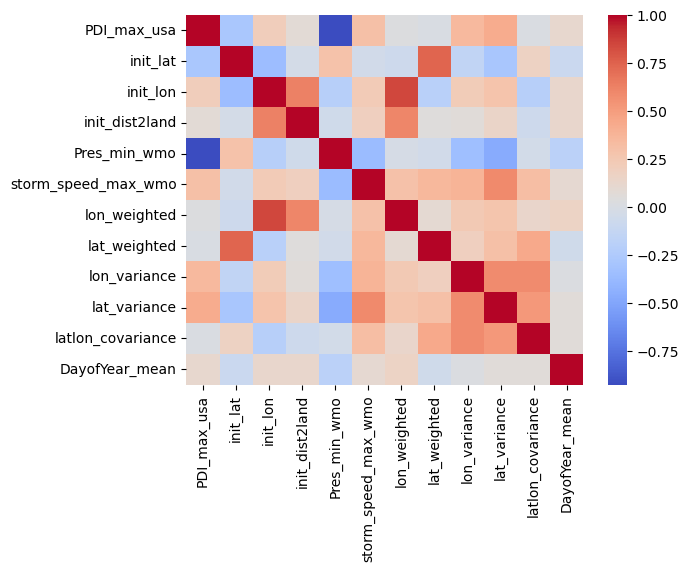

In [22]:
sn.heatmap(data = columns_corr, cmap = 'coolwarm')
# This heatmap shows clear negative correlation with Pres_min_wmo, which is physically intuitive. 
# However, if Pres_min_wmo is from any time in the storm’s lifetime (not only the initial state),
# it might be tautologically correlated with high final intensity (and thus high PDI)
# We still want to use min pressure despite of this to in the study of feature importance. 

### Build features

In [23]:
def build_Xy(df, feature_cols, target_col='PDI_max_usa'):
    df_subset = df[feature_cols].copy()
    # fill na with mean:
    for col in feature_cols:
        df_subset[col] = df_subset[col].fillna(df_subset[col].mean())
    predictor_cols = [x for x in feature_cols if x != target_col]
    X = df_subset[predictor_cols].copy()
    y = df_subset[target_col].copy()
    
    return X, y

In [24]:
X, y = build_Xy(features_df, feature_cols=columns_used, target_col='PDI_max_usa')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Simple linear regression

In [25]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

train_score = linreg.score(X_train, y_train)
test_score = linreg.score(X_test, y_test)

print("linear regression")
print("train R^2:", train_score)
print("test R^2:", test_score)

print("coefficients: ")
coef_dict = zip(X.columns, linreg.coef_)
for feature, coef in coef_dict:
    print(f"{feature}: {coef}")
    
print("intercept:", linreg.intercept_)

linear regression
train R^2: 0.7307258971787837
test R^2: 0.7280858154966459
coefficients: 
init_lat: -2684166.5173710342
init_lon: 1242595.7661174564
init_dist2land: 16114.511760400692
Pres_min_wmo: -10809974.231863497
storm_speed_max_wmo: 1091628.45183507
lon_weighted: -2327756.51854208
lat_weighted: 2043972.188007621
lon_variance: 282681.62296632316
lat_variance: 305412.939609037
latlon_covariance: -479611.8270995628
DayofYear_mean: 119039.46911525216
intercept: 10638380198.173347


### Random forest

In [26]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

train_score_rf = rf.score(X_train, y_train)
test_score_rf = rf.score(X_test, y_test)
print("random forest regressor")
print("train R^2:", train_score_rf)
print("test R^2:", test_score_rf)

importances = rf.feature_importances_
for feat_name, imp in zip(X.columns, importances):
    print(f"{feat_name} importance: {imp:.4f}")

random forest regressor
train R^2: 0.9761559840338515
test R^2: 0.813363666640597
init_lat importance: 0.0152
init_lon importance: 0.0114
init_dist2land importance: 0.0128
Pres_min_wmo importance: 0.8138
storm_speed_max_wmo importance: 0.0132
lon_weighted importance: 0.0139
lat_weighted importance: 0.0197
lon_variance importance: 0.0192
lat_variance importance: 0.0489
latlon_covariance importance: 0.0181
DayofYear_mean importance: 0.0137


### PCA

In [27]:
# combine train + test for a PCA on the entire dataset 
# because PCA is unsupervised, we can just do it on X to see overall structure
X_full = pd.concat([X_train, X_test])
scaler_pca = StandardScaler()
X_full_scaled = scaler_pca.fit_transform(X_full)

pca = PCA(n_components=3)
pca.fit(X_full_scaled)

print("PCA results (3 components):")
print("explained variance ratio:", pca.explained_variance_ratio_)

# optionally transform X to get principal components
X_pcs = pca.transform(X_full_scaled)

PCA results (3 components):
explained variance ratio: [0.29866344 0.21695998 0.15144609]


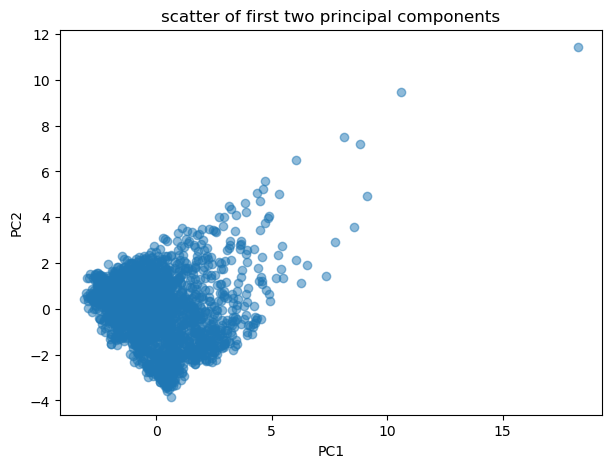

In [28]:
plt.figure(figsize=(7,5))
plt.scatter(X_pcs[:,0], X_pcs[:,1], alpha=0.5)
plt.title("scatter of first two principal components")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()
# there isn't a particularly clear clustering pattern from the two principal components

In [29]:
loadings = pca.components_.T  # shape (n_features, n_components)
for i, col in enumerate(X.columns):
    print(f"feature {col}: PC1 loading={loadings[i,0]:.3f}, PC2 loading={loadings[i,1]:.3f}, PC3 loading={loadings[i,2]:.3f}")


feature init_lat: PC1 loading=-0.121, PC2 loading=0.390, PC3 loading=0.538
feature init_lon: PC1 loading=0.352, PC2 loading=-0.438, PC3 loading=0.177
feature init_dist2land: PC1 loading=0.276, PC2 loading=-0.286, PC3 loading=0.399
feature Pres_min_wmo: PC1 loading=-0.236, PC2 loading=-0.009, PC3 loading=0.359
feature storm_speed_max_wmo: PC1 loading=0.382, PC2 loading=0.158, PC3 loading=-0.030
feature lon_weighted: PC1 loading=0.380, PC2 loading=-0.253, PC3 loading=0.366
feature lat_weighted: PC1 loading=0.152, PC2 loading=0.485, PC3 loading=0.380
feature lon_variance: PC1 loading=0.377, PC2 loading=0.188, PC3 loading=-0.226
feature lat_variance: PC1 loading=0.441, PC2 loading=0.158, PC3 loading=-0.237
feature latlon_covariance: PC1 loading=0.259, PC2 loading=0.426, PC3 loading=-0.059
feature DayofYear_mean: PC1 loading=0.115, PC2 loading=-0.096, PC3 loading=-0.024


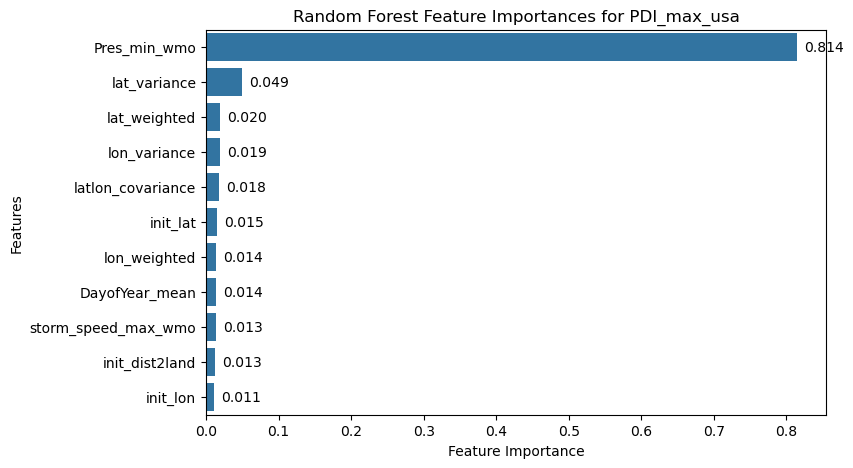

In [35]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]  # descending sort
feature_names = X.columns[indices]
sorted_importances = importances[indices]

plt.figure(figsize=(8, 5))
ax = sns.barplot(x=sorted_importances, y=feature_names, orient='h')

# Annotate each bar with its importance value
for i, v in enumerate(sorted_importances):
    ax.text(v + 0.01, i, f"{v:.3f}", va='center')

plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Random Forest Feature Importances for PDI_max_usa")
plt.show()

## Step 3: Clustering algorithms

## Step 4: Cluster analysis and evaluation